<html>
<h1>Projeto Prevenção de Rotatividade de Vendedores 
<h4>(Etapa atual: Feature Engineering e Machine Learning)
<br><br>
<h4>Autor: Uéliton de Brito Viana

<h4>Linkedin: <a href="https://www.linkedin.com/in/ueliton-viana/">linkedin.com/in/ueliton-viana/</a>

<h4>Github: <a href="https://github.com/Uellwar">github.com/Uellwar</a>

<h4>Kaggle: <a href="https://www.kaggle.com/uelitonviana/code">kaggle.com/uelitonviana</a>

</html>

<html><h1> Apresentação do projeto:

Esta é a **segunda etapa** do projeto, onde foram definidas as variáveis por onde os modelos aprenderão os padrões nos dados. Nesta fase também, os modelos foram escolhidos, treinados, melhorados, avaliados e salvos para uso posterior. Ao final deste Notebook, deixarei algumas dúvidas de negócio (extraídas na primeira etapa) que poderão se tornar novas variáveis/características para melhorar ainda mais o resultado dos modelos numa versão de upgrade.

O projeto se trata de uma hipotética situação, onde a empresa (de E-commerce) Olist gostaria de melhorar seus negócios por meio de Data Science. Em primeiro lugar, essa empresa define qual problema está tentando resolver. No caso, ela identificou que é cinco vezes mais caro adquirir novos vendedores do que reter os atuais. Logo, o problema é aumentar a taxa de retenção de vendedores para diminuir custos. Uma possível solução de Data Science é construir um modelo de Machine Learning para prever o churn. Depois, esse modelo é avaliado de maneira simplista (para fins didáticos), por fim, é implementado.

Decidi usar SQL para a etapa de *Feature Engineering* e Python para as demais. 
Os dados utilizados são os mesmos da <a href="https://github.com/Uellwar/Olist_Churn_Sellers">etapa anterior</a>, disponíveis <a href="https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce">aqui</a> através da plataforma Kaggle. Importei esses dados para o formato de banco de dados (olist.db) e utilizei neste projeto (e pode ser baixado <a href="https://drive.google.com/file/d/1Izf92Rm_-js4IC4RspEaEOa1Bl8Q2gAY/view?usp=sharing">clicando aqui</a>).

Observações: Um dos critérios de escolha dos modelos foi o tempo de processamento (custo computacional), por esse motivo em algumas células do notebook tem o comando `%%time` que calcula justamente o tempo de execução da mesma.
</html>

**Ok, mas o que fazer para melhorar os resultados já obtidos?**

Devido a minha pouca experiência com projetos de Data Science, muitas coisas podem ser utilizadas para melhorar os desempenhos dos modelos, portanto, listo algumas delas abaixo:

• Criação de novas variáveis explicativas (ver o final deste notebook).

• Clusterização de clientes por meio de modelos estatísticos.

• Detecção e correção e Underfitting e Overfitting por meio de testes estatísticos e plotagens gráficas.

• Utilização de modelos performáticos como GBMLight, XGBoosting e Redes Neurais.

### As Ferramentas, os Modelos Testados e o Dicionário de Variáveis

**Ferramentas Utilizadas:**

• SQL

• Python

=================================

**Modelos Testados:**

• LogisticRegression

• SVM

• KNeighborsClassifier

• GaussianNB

• ExtraTreesClassifier

• RandomForestClassifier

• AdaBoostClassifier

• GradientBoostingClassifier

=================================

**Modelos com melhores performance:**

• Ensemble(LR, KNN, ADA e Random Forest)

• AdaBoostClassifier ()


Dicionário de Variáveis:

Variável|                  Tipo|       Descrição
-------------------------|------------|------------------
avg_review_score|          float64|Média das Avaliações
idade_base_dias|           float64|Idade na base em dias
idade_base_mes|            int64  |Idade na base em meses
qtde_dias_utl_venda|       int64  |Dias desde a última venda
qtde_mes_ativacao|         int64  |Quantidade de meses que o vendedor vendeu
prop_ativacao|             float64|Proporção de meses em que o vendedor vendeu
prop_atraso|               int64  |Proporção de pedidos em atraso
avg_tempo_entrega_est|     int64  |Tempo médio previso para entrega
receita_total|             float64|Total vendido no período
avg_vl_venda|              float64|Receita média por venda
avg_vl_venda_mes|          float64|Receita média mensal
avg_vl_venda_mes_ativado|  float64|Receita média por mês em que vendedor ativa
qtde_vendas|               int64  |Total de vendas no período
qtde_produto|              int64  |Total de produtos vendidos no período
qtde_produto_dst|          int64  |Total de prod. distintos vendidos 
avg_vl_produto|            float64|Média do valor dos produtos vendidos
avg_qtde_produto_venda|    int64  |Média de produtos vendidos por venda
flag_vendeu|               int64  |0 ou 1 (1 se vendeu. 0 se churn.)




<h2>Sem mais. Vamos codar! \o/

### Importando as libs e configurando o ambiente

In [ ]:
# Coleta, e Manipulação dos dados e datas
import pandas as pd
import numpy as np
import sqlite3
from scipy.stats import randint, uniform
from datetime import timedelta

# Plotagens interativas
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go

# Divisão dos dados
from sklearn.model_selection import train_test_split, StratifiedKFold

# Processando variáveis
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

# Seleção de modelos e características
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Avaliação dos modelos
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Configuração do ambiente
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Criando a semente para reprodutividade
seed=3
np.random.seed(seed)

### Coletando os dados

<h3>Mas... Como definir quando é Churn?</h3>

<h5>
Nosso objetivo é prever os vendedores que deixarão a empresa. O conjunto de dados não vem pré-carregado com informações de rotatividade. Então, como determinamos se um vendedor se desligou? Neste exemplo específico, um vendedor se desconecta da Olist se dentro dos próximos 30 dias, ele não efetuar venda. Então, projetei o recurso churn definindo uma variável `flag_vendeu` com valores 0 (Não vendeu! Logo, churn) e 1 (Vendeu! Logo, não churn). 

Os dados serão agrupados pelo recurso `seller_id` contendo o histórico de 3 meses, ou seja, o modelo aprenderá com o histórico dos 3 meses e tentará prever se dentro dos próximos 30 dias ocorrerá ou não a rotatividade (caso ocorra venda, a empresa entende que não há abandono).

A "janela" de tempo nos dados funcionará da seguinte maneira:

1ª janela de tempo: 

1. dt_train_start: primeiro dia do primeiro mês

2. dt_train_stop: último dia do 3º mês

3. periodo_decorrido: 90 dias (3 meses de treinamento)

4. periodo_de_churn: *caso o vendedor não efetuar vendas nos os próximos 30 dias* então a variável `flag_vendeu` receberá o valor 0, e 1 caso efetue vendas neste período.

<br>

`Resumindo: O modelo aprenderá com o histórico de 3 meses e tentará prever uma possível venda nos próximos 30 dias.`

**Ao fim desta 1ª janela, TODAS as datas se moverão 4 meses para frente e então o processo acima é repetido.**

Obs: Uma outra modificação futura para possível melhora dos resultados será:
*Ao fim desta 1ª janela, TODAS as datas "se moverão" 1 mês para frente e então o processo acima é repetido.*
<br>

-----

In [ ]:
# Prepararando os dados

# Abrindo a conexão
conn = sqlite3.connect('/content/drive/MyDrive/Github/SQL/Dados/Olist/data/olist.db')
cursor = conn.cursor()

# Listando as tabelas disponíveis
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
tables = cursor.fetchall()

In [ ]:
print('Tabelas disponíveis\n')
[i[0] for i in tables]

Tabelas disponíveis



['tb_customers',
 'tb_geolocation',
 'tb_order_items',
 'tb_order_payments',
 'tb_order_reviews',
 'tb_orders',
 'tb_product_category_name_translation',
 'tb_products',
 'tb_sellers']

In [ ]:
# Selecionando apenas a coluna com as datas das vendas
query_date = "SELECT order_approved_at FROM tb_orders"
df_date = pd.read_sql(query_date, conn)
df_date['order_approved_at'] = pd.to_datetime(df_date['order_approved_at'])

In [ ]:
dt_max = df_date['order_approved_at'].max()
dt_train_start = df_date.loc[df_date['order_approved_at'].dt.year >=2017]['order_approved_at'].min()
diff = abs(dt_train_start - dt_max)

In [ ]:
count = 0
dates = {'dt_train_start':[],'dt_train_stop':[],'dt_test_start':[],'dt_test_stop':[]}

while diff.days >= 211: # 211: Total de dias de cada foto
  if count > 0:
    dt_train_start = dt_test_stop + timedelta(days=1)
  
  dt_train_stop = dt_train_start + timedelta(days=90)
  dt_test_start =  dt_train_stop + timedelta(days=1)
  dt_test_stop = dt_test_start + timedelta(days=30)
  count += 1
  
  dates['dt_train_start'].append(dt_train_start.strftime("%Y-%m-%d"))
  dates['dt_train_stop'].append(dt_train_stop.strftime("%Y-%m-%d"))
  dates['dt_test_start'].append(dt_test_start.strftime("%Y-%m-%d"))
  dates['dt_test_stop'].append(dt_test_stop.strftime("%Y-%m-%d"))
  diff = abs(dt_train_start - dt_max)

In [ ]:
# Blocos das datas utilizadas
for i in range(len(dates['dt_train_start'])):
  print(f'{i+1}º Foto')
  print(dates['dt_train_start'][i]) # Data de início do treinamento
  print(dates['dt_train_stop'][i]) # Data final do treinamento
  print(dates['dt_test_start'][i]) # Data de início da predição (flag)
  print(dates['dt_test_stop'][i]) # Data final da predição (flag)
  print('\n')

1º Foto
2017-01-05
2017-04-05
2017-04-06
2017-05-06


2º Foto
2017-05-07
2017-08-05
2017-08-06
2017-09-05


3º Foto
2017-09-06
2017-12-05
2017-12-06
2018-01-05


4º Foto
2018-01-06
2018-04-06
2018-04-07
2018-05-07


5º Foto
2018-05-08
2018-08-06
2018-08-07
2018-09-06




In [ ]:
# Criando um df vazio para receber as fotos
df = pd.DataFrame()

# Criando a query
for i in range(len(dates['dt_train_start'])):
  query =f""" 
  WITH tb_book_sellers AS (

    WITH idade_base_seller AS (
    SELECT t2_idade_base_with.seller_id,
          MAX(JULIANDAY('{dates['dt_train_stop'][i]}') - JULIANDAY(t1_orders_idade.order_approved_at)) AS idade_base

    FROM tb_orders AS t1_orders_idade

    LEFT JOIN tb_order_items AS t2_idade_base_with
    ON t1_orders_idade.order_id = t2_idade_base_with.order_id

    WHERE t1_orders_idade.order_approved_at < '{dates['dt_train_stop'][i]}'
    AND t1_orders_idade.order_status = 'delivered'

    GROUP BY t2_idade_base_with.seller_id
    ) -- fim do with idade_base_seller


    SELECT  t2_seller_2.seller_city,
            t2_seller_2.seller_state,
            t1_from_master.*

    FROM (
          SELECT t2_seller_1.seller_id,

                AVG( t5_reviews.review_score ) AS avg_review_score, -- media do score de reviews
            
                t3_idade_base.idade_base AS idade_base_dias, -- dias desde a primeira venda
                1 + CAST(t3_idade_base.idade_base / 30 AS integer) AS idade_base_mes, -- meses desde a primeira venda
                CAST( JULIANDAY('{dates['dt_train_stop'][i]}') - JULIANDAY( MAX( t1_orders_1.order_approved_at ) ) AS integer) AS qtde_dias_utl_venda, 

                COUNT( DISTINCT STRFTIME('%m', t1_orders_1.order_approved_at) ) AS qtde_mes_ativacao, 
                CAST( COUNT( DISTINCT STRFTIME('%m', t1_orders_1.order_approved_at) ) AS FLOAT) / MIN( 1 + CAST( t3_idade_base.idade_base / 30 AS integer), 6 ) AS prop_ativacao, -- proporcao de meses em que vendedor vendeu

                SUM( CASE WHEN JULIANDAY(t1_orders_1.order_estimated_delivery_date) < JULIANDAY(t1_orders_1.order_delivered_customer_date) THEN 1 ELSE 0 END ) / COUNT( DISTINCT t2_seller_1.order_id) AS prop_atraso, -- proporcao de pedidos em atraso
                CAST( AVG( JULIANDAY(t1_orders_1.order_estimated_delivery_date) - JULIANDAY( t1_orders_1.order_purchase_timestamp ) ) AS integer) AS avg_tempo_entrega_est, -- tempo medio de entrega prevista

                SUM( t2_seller_1.price ) AS receita_total,
                SUM( t2_seller_1.price ) / COUNT( DISTINCT t2_seller_1.order_id) AS avg_vl_venda,
                SUM( t2_seller_1.price ) / MIN( 1 + CAST( t3_idade_base.idade_base / 30 AS integer), 6 ) AS avg_vl_venda_mes, -- receita média por mes simples
                SUM( t2_seller_1.price ) / COUNT( DISTINCT STRFTIME('%m', t1_orders_1.order_approved_at) ) AS avg_vl_venda_mes_ativado, -- receita média por mes em que vendedor ativa
                COUNT( DISTINCT t2_seller_1.order_id) AS qtde_vendas,

                COUNT( t2_seller_1.product_id ) AS qtde_produto,
                COUNT( DISTINCT t2_seller_1.product_id ) AS qtde_produto_dst,
                SUM( t2_seller_1.price ) / COUNT( t2_seller_1.product_id ) AS avg_vl_produto,

                COUNT( t2_seller_1.product_id ) / COUNT( DISTINCT t2_seller_1.order_id) AS avg_qtde_produto_venda -- media de produtos vendidos por venda

          FROM tb_orders AS t1_orders_1

          LEFT JOIN tb_order_items AS t2_seller_1
          ON t1_orders_1.order_id = t2_seller_1.order_id

          LEFT JOIN idade_base_seller AS t3_idade_base
          ON t2_seller_1.seller_id = t3_idade_base.seller_id

          LEFT JOIN tb_products AS t4_produtos
          ON t2_seller_1.product_id = t4_produtos.product_id

          LEFT JOIN tb_order_reviews AS t5_reviews
          ON t1_orders_1.order_id = t5_reviews.order_id

          WHERE t1_orders_1.order_approved_at between '{dates['dt_train_start'][i]}'
          AND '{dates['dt_train_stop'][i]}'
          AND t1_orders_1.order_status = 'delivered'

          group by t2_seller_1.seller_id
    ) AS t1_from_master

    LEFT JOIN tb_sellers AS t2_seller_2
    ON t1_from_master.seller_id = t2_seller_2.seller_id

    ORDER BY qtde_vendas desc
  ) -- fim do with tb_book_sellers


  SELECT t1_book.*,
          CASE WHEN t2_flag.seller_id is not null THEN 1 ELSE 0 end AS flag_vendeu

  FROM tb_book_sellers AS t1_book

  LEFT JOIN(
      SELECT DISTINCT t2.seller_id

      FROM tb_orders AS tb_orders_join

      LEFT JOIN tb_order_items AS t2
      ON tb_orders_join.order_id = t2.order_id

      WHERE tb_orders_join.order_approved_at between '{dates['dt_test_start'][i]}'
      AND '{dates['dt_test_stop'][i]}'
      AND tb_orders_join.order_status = 'delivered'
  ) AS t2_flag
  ON t1_book.seller_id = t2_flag.seller_id -- join do book com o flag
  """
  print(f'df antes (shape): {df.shape}')
  df_query = pd.read_sql(query, conn)
  print(f'df_query (shape): {df_query.shape}')
  df = pd.concat([df,df_query],axis=0)
  print(f'df depois (shape): {df.shape}\n')
del df_query

df antes (shape): (0, 0)
df_query (shape): (632, 21)
df depois (shape): (632, 21)

df antes (shape): (632, 21)
df_query (shape): (843, 21)
df depois (shape): (1475, 21)

df antes (shape): (1475, 21)
df_query (shape): (1207, 21)
df depois (shape): (2682, 21)

df antes (shape): (2682, 21)
df_query (shape): (1372, 21)
df depois (shape): (4054, 21)

df antes (shape): (4054, 21)
df_query (shape): (1741, 21)
df depois (shape): (5795, 21)



In [ ]:
# Colunas qualitativas removidas temporariamente para fins de simplificação
cols_quali = ['seller_city', 'seller_state', 'seller_id']
df.drop(cols_quali, axis=1, inplace=True)

### Visualizando os dados

In [ ]:
# O dataframe não possui nem valores nulos e nem categóricos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5795 entries, 0 to 1740
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   avg_review_score          5795 non-null   float64
 1   idade_base_dias           5795 non-null   float64
 2   idade_base_mes            5795 non-null   int64  
 3   qtde_dias_utl_venda       5795 non-null   int64  
 4   qtde_mes_ativacao         5795 non-null   int64  
 5   prop_ativacao             5795 non-null   float64
 6   prop_atraso               5795 non-null   int64  
 7   avg_tempo_entrega_est     5795 non-null   int64  
 8   receita_total             5795 non-null   float64
 9   avg_vl_venda              5795 non-null   float64
 10  avg_vl_venda_mes          5795 non-null   float64
 11  avg_vl_venda_mes_ativado  5795 non-null   float64
 12  qtde_vendas               5795 non-null   int64  
 13  qtde_produto              5795 non-null   int64  
 14  qtde_pro

In [ ]:
# Visualizando os dados
df.head()

,avg_review_score,idade_base_dias,idade_base_mes,qtde_dias_utl_venda,qtde_mes_ativacao,prop_ativacao,prop_atraso,avg_tempo_entrega_est,receita_total,avg_vl_venda,avg_vl_venda_mes,avg_vl_venda_mes_ativado,qtde_vendas,qtde_produto,qtde_produto_dst,avg_vl_produto,avg_qtde_produto_venda,flag_vendeu
0,3.903382,182.563808,7,0,4,0.666667,0,34,16494.76,98.771018,2749.126667,4123.6900,167,207,123,79.684831,1,1
1,4.549618,182.425648,7,0,4,0.666667,0,30,24525.30,201.027049,4087.550000,6131.3250,122,131,28,187.216031,1,1
2,4.008929,86.593611,3,0,4,1.333333,0,26,10722.40,107.224000,3574.133333,2680.6000,100,112,46,95.735714,1,1
3,4.030000,180.867674,7,0,4,0.666667,0,26,2351.47,26.127444,391.911667,587.8675,90,100,51,23.514700,1,1
4,3.405405,68.045023,3,0,4,1.333333,0,32,14786.63,166.141910,4928.876667,3696.6575,89,111,50,133.212883,1,1


In [ ]:
# Visualizando as estatísticas dos dados
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_review_score,5795.0,4.111717,0.906045,1.000000,3.800000,4.300000,4.812500,5.000000
idade_base_dias,5795.0,184.299051,155.033672,0.062199,58.436088,142.852303,284.594201,670.569873
idade_base_mes,5795.0,6.666782,5.191426,1.000000,2.000000,5.000000,10.000000,23.000000
qtde_dias_utl_venda,5795.0,19.711130,23.299207,0.000000,2.000000,9.000000,30.500000,89.000000
qtde_mes_ativacao,5795.0,2.282657,1.115910,1.000000,1.000000,2.000000,3.000000,4.000000
prop_ativacao,5795.0,0.651311,0.382242,0.166667,0.333333,0.600000,1.000000,2.000000
prop_atraso,5795.0,0.033650,0.219218,0.000000,0.000000,0.000000,0.000000,5.000000
avg_tempo_entrega_est,5795.0,23.893874,7.094069,2.000000,20.000000,23.000000,27.000000,146.000000
receita_total,5795.0,1693.805446,4233.969712,3.540000,169.900000,525.380000,1465.415000,96868.820000
avg_vl_venda,5795.0,189.632173,367.772105,3.245000,59.283333,104.833333,188.970000,13440.000000


In [ ]:
# Removendo colunas com correlação maior que 90% 
cols_const = ['idade_base_mes','avg_vl_venda_mes','qtde_produto']
df.drop(cols_const, axis=1, inplace=True)

In [ ]:
# É preciso usar o método de estratificação devido a diferença de tamanho das classes afim de manter a mesma distribuição em nosso treino e teste.
names = ['Não Churn','Churn']
values = df['flag_vendeu'].value_counts(normalize=True).values
values = [round(value,3) for value in values]

fig = px.bar(x=names, y=values, width=550, height=400, text=values)
fig.update_layout(title={
      'text':'Proporção da classe Churn',
      'x':0.5,
      'xanchor':'center'})
fig.show()

### Dividindo e filtrando os dados

In [ ]:
y = df['flag_vendeu']
df = df.iloc[:,:19].copy()
df['flag_vendeu'] = y

In [ ]:
df.head()

,avg_review_score,idade_base_dias,qtde_dias_utl_venda,qtde_mes_ativacao,prop_ativacao,prop_atraso,avg_tempo_entrega_est,receita_total,avg_vl_venda,avg_vl_venda_mes_ativado,qtde_vendas,qtde_produto_dst,avg_vl_produto,avg_qtde_produto_venda,flag_vendeu
0,3.903382,182.563808,0,4,0.666667,0,34,16494.76,98.771018,4123.6900,167,123,79.684831,1,1
1,4.549618,182.425648,0,4,0.666667,0,30,24525.30,201.027049,6131.3250,122,28,187.216031,1,1
2,4.008929,86.593611,0,4,1.333333,0,26,10722.40,107.224000,2680.6000,100,46,95.735714,1,1
3,4.030000,180.867674,0,4,0.666667,0,26,2351.47,26.127444,587.8675,90,51,23.514700,1,1
4,3.405405,68.045023,0,4,1.333333,0,32,14786.63,166.141910,3696.6575,89,50,133.212883,1,1


In [ ]:
# Divisão dos dados em treino e teste
#X =  df.iloc[:,:-1]
#Y = df.iloc[:,-1]
X = df.iloc[:,:-1]
Y = df['flag_vendeu']
X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                                   test_size=0.3,
                                                   random_state=seed,
                                                   stratify=df['flag_vendeu'])

In [ ]:
X_train.shape, X_test.shape

((4056, 14), (1739, 14))

In [ ]:
# Função que recebe o df, padroniza-o e retorna as características mais relevantes por meio de Permutação.
def relevance(data, flag):
  # Selecionando as colunas
  feature_names = data.columns.tolist()
  feature_names.remove(flag)
  X = data[feature_names]
  y = data[flag]

  # Padronizando os dados para permutação
  scaler = StandardScaler().fit(X)
  X = scaler.transform(X)
  
  # Separando os dados
  X_train, X_test, y_train, y_test = train_test_split(X, y , stratify=y, random_state=seed)

  # Instanciando e treinando o modelo
  forest = RandomForestClassifier(random_state=seed)
  forest.fit(X_train, y_train)

  # Calculando a importância e o Desvio Padrão de cada característica e transformando num objeto Series do pandas
  result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=2)
  forest_importances = pd.Series(result.importances_mean, index=feature_names)
  forest_importances = forest_importances[forest_importances > 0]
  forest_importances.sort_values(ascending=False,inplace=True)
  std = result.importances_std

  # Criando o Gráfico das informações e retornando tanto o gráfico quanto as colunas
  fig = px.bar(forest_importances, error_y=None, width=800, height=450, text_auto='.2s')
  fig.update_layout(title={"text":"Importância das Características dos Produtos", "x":0.5},showlegend=False)
  return fig, forest_importances.index

In [ ]:
graf_import, cols_imp = relevance(df, flag='flag_vendeu')

In [ ]:
# Criando um dataframe filtrado para comparação de desempenho dos modelos
X_train_f = X_train[cols_imp]
X_test_f = X_test[cols_imp]

### Criando as funções para instanciar e treinar os modelos

In [ ]:
# Step models para o Pipeline
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))

    return basedModels

In [ ]:
# BasedLine dos modelos
def BasedLine2(X_train, y_train,models,obs):
    # Parâmetros e Métricas
    num_folds = 10
    scoring = 'roc_auc'

    results = []
    names = []
    dict_models = {'Models':[],'AUC':[],'Std':[]}
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        dict_models['Models'].append(name+obs)
        dict_models['AUC'].append(cv_results.mean())
        dict_models['Std'].append(cv_results.std())
        
    return names, results, dict_models

In [ ]:
# Plotagem da distribuição do desempenho
class PlotBoxR(object):
    # Calcula o boxplot para o modelo selecionado
    def __Trace(self,nameOfFeature,value): 
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(color = 'rgb(0, 128, 128)',)
        )
        return trace

    # Envia cada uma dos modelos para a função acima e retorna o conjunto com os boxplots
    def PlotResult(self,names,results):
        data = []
        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))
        py.iplot(data)

In [ ]:
# Converte os dados de desempenho dos modelos num DataFrame pandas
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=6):
        prc = "{:."+str(dec)+"f}" 
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean()))

    scoreDataFrame = pd.DataFrame({'Model':names, 'AUC': scores})
    return scoreDataFrame

In [ ]:
# Seleciona o tipo de padronização desejada e retorna um step para o Pipe
def GetScaledModel(nameOfScaler):
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append(('LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append(('KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append(('NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append(('AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append(('GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append(('RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append(('ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))

    return pipelines 

### Instanciando e treinando os modelos para os dados completos (21 características)

In [ ]:
# Treinando os modelos com os dados originais
models = GetBasedModel()
names, results, dict_model = BasedLine2(X_train, y_train,models,'_BasedLine')
PlotBoxR().PlotResult(names,results)

In [ ]:
basedLineScore = ScoreDataFrame(dict_model['Models'],dict_model['AUC']).sort_values(by='AUC', ascending=False)
print(f'Média dos 5 melhores: \n{round(basedLineScore["AUC"].head().mean(),6)}')
basedLineScore.head()

Média dos 5 melhores: 
0.806669


,Model,AUC
4,GBM_BasedLine,0.814503
0,LR_BasedLine,0.813957
3,AB_BasedLine,0.805442
5,RF_BasedLine,0.800480
2,NB_BasedLine,0.798962


In [ ]:
# Treinando com o método StandardScaler
models = GetScaledModel('standard')
names, results, dict_model = BasedLine2(X_train, y_train,models,'_standard')
PlotBoxR().PlotResult(names,results)

scaledScoreStandard = ScoreDataFrame(dict_model['Models'],dict_model['AUC'])
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard], axis=0).sort_values(by='AUC', ascending=False)

In [ ]:
print(f'Média dos 5 melhores: \n{round(scaledScoreStandard["AUC"].head().mean(),6)}')
scaledScoreStandard.head().sort_values(by='AUC', ascending=False)

Média dos 5 melhores: 
0.79662


,Model,AUC
4,GBM_standard,0.814897
0,LR_standard,0.812109
3,AB_standard,0.805455
2,NB_standard,0.797720
1,KNN_standard,0.752919


In [ ]:
# Dataset Normal com minmax
models = GetScaledModel('minmax')
names,results,dict_model = BasedLine2(X_train, y_train,models,'_minmax')
PlotBoxR().PlotResult(names,results)

scaledScoreMinMax = ScoreDataFrame(dict_model['Models'],dict_model['AUC'])
compareModels = pd.concat([compareModels,
                          scaledScoreMinMax], axis=0).sort_values(by='AUC', ascending=False)

In [ ]:
print(f'Média dos 5 melhores: \n{round(scaledScoreMinMax["AUC"].head().mean(),6)}')
scaledScoreMinMax.head().sort_values(by='AUC', ascending=False)

Média dos 5 melhores: 
0.79441


,Model,AUC
4,GBM_minmax,0.815807
0,LR_minmax,0.807260
3,AB_minmax,0.797933
2,NB_minmax,0.797867
1,KNN_minmax,0.753184


### Instanciando e treinando os modelos para os dados filtrados (11 características)

In [ ]:
# Treinando os modelos com os dados originais
models = GetBasedModel()
names_f, results_f, dict_model_f = BasedLine2(X_train_f, y_train, models, '_BasedLine_f')
PlotBoxR().PlotResult(names_f,results_f)
basedLineScore_f = ScoreDataFrame(dict_model_f['Models'],dict_model_f['AUC']).sort_values(by='AUC', ascending=False)

In [ ]:
print(f'Média dos 5 melhores: \n{round(basedLineScore_f["AUC"].head().mean(),6)}')
basedLineScore_f.head().sort_values(by='AUC', ascending=False)

Média dos 5 melhores: 
0.806134


,Model,AUC
4,GBM_BasedLine_f,0.814946
0,LR_BasedLine_f,0.814227
3,AB_BasedLine_f,0.806018
5,RF_BasedLine_f,0.798552
2,NB_BasedLine_f,0.796928


In [ ]:
# Dataset Filtrado com standard
models = GetScaledModel('standard')
names_f,results_f,dict_model_f = BasedLine2(X_train_f, y_train,models,'_standard_f')
PlotBoxR().PlotResult(names_f,results_f)

scaledScoreStandard_f = ScoreDataFrame(dict_model_f['Models'],dict_model_f['AUC'])
compareModels_f = pd.concat([basedLineScore_f,
                           scaledScoreStandard_f], axis=0).sort_values(by='AUC', ascending=False)

In [ ]:
print(f'Média dos 5 melhores: \n{round(scaledScoreStandard_f["AUC"].head().mean(),6)}')
scaledScoreStandard_f.head().sort_values(by='AUC', ascending=False)

Média dos 5 melhores: 
0.79682


,Model,AUC
4,GBM_standard_f,0.815230
0,LR_standard_f,0.812509
3,AB_standard_f,0.806416
2,NB_standard_f,0.795348
1,KNN_standard_f,0.754597


In [ ]:
# Dataset Filtrado com minmax
models = GetScaledModel('minmax')
names_f,results_f,dict_model_f = BasedLine2(X_train_f, y_train,models,'_minmax_f')
PlotBoxR().PlotResult(names_f,results_f)

scaledScoreMinMax_f = ScoreDataFrame(dict_model_f['Models'],dict_model_f['AUC'])
compareModels_f = pd.concat([compareModels_f,
                          scaledScoreMinMax_f], axis=0).sort_values(by='AUC', ascending=False)

In [ ]:
print(f'Média dos 5 melhores: \n{round(scaledScoreMinMax_f["AUC"].head().mean(),6)}')
scaledScoreMinMax_f.head().sort_values(by='AUC', ascending=False)

Média dos 5 melhores: 
0.796522


,Model,AUC
4,GBM_minmax_f,0.813724
3,AB_minmax_f,0.807341
0,LR_minmax_f,0.803772
2,NB_minmax_f,0.795372
1,KNN_minmax_f,0.762402


### Conjunto de modelos para tunar os hiperparâmetros

In [ ]:
# Conjunto de modelos a serem tunados (Todas as características)
print(f'Média: {round(basedLineScore["AUC"].head().mean(),6)}')
basedLineScore.head().sort_values(by='AUC', ascending=False)

Média: 0.806669


,Model,AUC
4,GBM_BasedLine,0.814503
0,LR_BasedLine,0.813957
3,AB_BasedLine,0.805442
5,RF_BasedLine,0.800480
2,NB_BasedLine,0.798962


In [ ]:
# Conjunto de modelos a serem tunados (Características Selecionadas)
print(f'Média: {round(basedLineScore_f["AUC"].head().mean(),6)}')
basedLineScore_f.head().sort_values(by='AUC', ascending=False)

Média: 0.806134


,Model,AUC
4,GBM_BasedLine_f,0.814946
0,LR_BasedLine_f,0.814227
3,AB_BasedLine_f,0.806018
5,RF_BasedLine_f,0.798552
2,NB_BasedLine_f,0.796928


### Tunando os modelos com todos os dados

In [ ]:
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Função cria randomized search com 10-folds cross validation e 100 iterações
        cv = 4
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=seed,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 scoring='roc_auc'
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Melhor Score ROC_AUC: %f Usando %s" % (message))
        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

In [ ]:
class GridSearch(object):
    def __init__(self,X_train,y_train,model,hyperparameters,return_results_cv=False):
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Função cria randomized search com 10-folds cross validation e 100 iterações
        cv = 4
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                scoring='roc_auc'
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Melhor Score ROC_AUC: %f Usando %s" % (message))

        return best_model,best_model.best_params_, best_model.cv_results_
        
    def BestModelPridict(self,X_test):
        best_model,_,cv_result = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred, cv_result

In [ ]:
def floatingDecimals(f_val, dec=6):
        prc = "{:."+str(dec)+"f}"
        return float(prc.format(f_val))

In [ ]:
model = LogisticRegression()

# Penalização
penalty = ['l1', 'l2']

# Criar distribuição de hiperparâmetros de regularização usando distribuição uniforme
C = uniform(loc=0, scale=4)

# Cria opções de hiperparâmetro
hyperparameters_lr = dict(C=C, penalty=penalty)

In [ ]:
LR_RandSearch = RandomSearch(X_train,y_train,model,hyperparameters_lr)

In [ ]:
%%time
y_pred_lr = LR_RandSearch.BestModelPridict(X_test)
mean_score_lr = (y_test == y_pred_lr).mean()
print('Predição com os dados de X_test:' ,floatingDecimals(mean_score_lr))

Melhor Score ROC_AUC: 0.813934 Usando {'C': 0.8134181039835928, 'penalty': 'l2'}
Predição com os dados de X_test: 0.741231
CPU times: user 1.13 s, sys: 132 ms, total: 1.26 s
Wall time: 11.1 s


In [ ]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]
param_grid_ada = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [ ]:
%%time
model_Ad = AdaBoostClassifier()
Ad_GridSearch = GridSearch(X_train,y_train,model_Ad,param_grid_ada)

y_pred_ada = Ad_GridSearch.BestModelPridict(X_test)

mean_score_ada = (y_test == y_pred_ada[0]).mean()
print('Predição com os dados de X_test:' ,floatingDecimals(mean_score_ada))

Melhor Score ROC_AUC: 0.812896 Usando {'learning_rate': 0.05, 'n_estimators': 250}
Predição com os dados de X_test: 0.743531
CPU times: user 3.13 s, sys: 193 ms, total: 3.33 s
Wall time: 1min 31s


In [ ]:
%%time 
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid_knn = dict(n_neighbors=neighbors)

KNN_GridSearch = GridSearch(X_train,y_train,model_KNN,param_grid_knn)
y_pred_knn = KNN_GridSearch.BestModelPridict(X_test)

print('Predição com os dados de X_test:' ,floatingDecimals((y_test == y_pred_knn[0]).mean(),7))

Melhor Score ROC_AUC: 0.783452 Usando {'n_neighbors': 18}
Predição com os dados de X_test: 0.7297297
CPU times: user 339 ms, sys: 9.2 ms, total: 348 ms
Wall time: 1.75 s


In [ ]:
max_depth_value = [3, None]
max_features_value =  randint(1, 4)
min_samples_leaf_value = randint(1, 4)
criterion_value = ["gini", "entropy"]

param_grid_rf = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

In [ ]:
%%time
model_rf = RandomForestClassifier()
CART_RandSearch = RandomSearch(X_train,y_train,model_rf,param_grid_rf)
y_pred_rf = CART_RandSearch.BestModelPridict(X_test)
print('Predição com os dados de X_test:' ,floatingDecimals((y_test == y_pred_rf).mean(),7))

Melhor Score ROC_AUC: 0.813639 Usando {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 2}
Predição com os dados de X_test: 0.7383554
CPU times: user 4.33 s, sys: 254 ms, total: 4.58 s
Wall time: 2min 21s


### Tunando os modelos com os dados filtrados

In [ ]:
%%time
model_f = LogisticRegression()
LR_RandSearch_f = RandomSearch(X_train_f,y_train,model_f,hyperparameters_lr)
y_pred_lr_f = LR_RandSearch_f.BestModelPridict(X_test_f)

mean_score_lr_f = (y_test == y_pred_lr_f).mean()
print('Predição com os dados de X_test_f:' ,floatingDecimals(mean_score_lr_f,6))

Melhor Score ROC_AUC: 0.813454 Usando {'C': 2.0864173604591203, 'penalty': 'l2'}
Predição com os dados de X_test_f: 0.740656
CPU times: user 1.24 s, sys: 120 ms, total: 1.36 s
Wall time: 11.4 s


In [ ]:
%%time
model_Ad_f = AdaBoostClassifier()
Ad_GridSearch = GridSearch(X_train_f,y_train,model_Ad_f,param_grid_ada)

y_pred_ada_f = Ad_GridSearch.BestModelPridict(X_test_f)

mean_score_ada_f = (y_test == y_pred_ada_f[0]).mean()
print('Predição com os dados de X_test_f:' ,floatingDecimals(mean_score_ada_f,6))

Melhor Score ROC_AUC: 0.812773 Usando {'learning_rate': 0.05, 'n_estimators': 300}
Predição com os dados de X_test_f: 0.742381
CPU times: user 3.16 s, sys: 144 ms, total: 3.3 s
Wall time: 1min 19s


In [ ]:
%%time 
model_KNN_f = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid_knn = dict(n_neighbors=neighbors)

KNN_GridSearch = GridSearch(X_train_f,y_train,model_KNN_f,param_grid_knn)
y_pred_knn_f = KNN_GridSearch.BestModelPridict(X_test_f)
print('prediction on test set is:' ,floatingDecimals((y_test == y_pred_knn_f[0]).mean(),7))

Melhor Score ROC_AUC: 0.783642 Usando {'n_neighbors': 20}
prediction on test set is: 0.7257044
CPU times: user 278 ms, sys: 15.1 ms, total: 293 ms
Wall time: 1.47 s


In [ ]:
%%time
model_rf_f = RandomForestClassifier()
CART_RandSearch = RandomSearch(X_train_f,y_train,model_rf_f,param_grid_rf)
y_pred_rf_f = CART_RandSearch.BestModelPridict(X_test_f)
print('prediction on test set is:' ,floatingDecimals((y_test == y_pred_rf_f).mean(),7))

Melhor Score ROC_AUC: 0.814042 Usando {'criterion': 'gini', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1}
prediction on test set is: 0.7389304
CPU times: user 4.33 s, sys: 242 ms, total: 4.57 s
Wall time: 2min 10s


### Ensemble 

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
# Modelos que se sairam melhor (df original)
param = {'C': 2.0864173604591203, 'penalty': 'l2'}
model1 = LogisticRegression(**param)

param = {'n_neighbors': 18}
model2 = KNeighborsClassifier(**param)

param = {'learning_rate': 0.05, 'n_estimators': 200}
model3 = AdaBoostClassifier(**param)

model4 = RandomForestClassifier()

In [ ]:
# create the sub models
estimators = [('LR',model1), ('KNN',model2), ('ADa',model3), ('RF',model4)]

In [ ]:
# criando o modelo ensamble com dados normalizado
kfold = StratifiedKFold(n_splits=4, shuffle=True)
ensemble = VotingClassifier(estimators)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

In [ ]:
cv_results_ensemble = cross_val_score(ensemble, X_train,y_train, cv=kfold)
print('Acurácia usando Ensemble com dados de X_train: ',cv_results_ensemble.mean())

Acurácia usando Ensemble com dados de X_train:  0.7386587771203157


In [ ]:
%%time
ensemble_model = ensemble.fit(X_train,y_train)

CPU times: user 2.24 s, sys: 138 ms, total: 2.37 s
Wall time: 2.23 s


In [ ]:
%%time
y_pred_ensemble = ensemble_model.predict(X_test)

print('Acurácia usando Ensemble com dados de X_test:' , (y_test == y_pred_ensemble).mean())

Acurácia usando Ensemble com dados de X_test: 0.7441058079355952
CPU times: user 374 ms, sys: 94 ms, total: 468 ms
Wall time: 376 ms


In [ ]:
# Modelos que se sairam melhor (df filtrado)
param = {'C': 1.0996804284115949, 'penalty': 'l2'}
model1_f = LogisticRegression(**param)

param = {'n_neighbors': 20}
model2_f = KNeighborsClassifier(**param)

param = {'learning_rate': 0.1, 'n_estimators': 250}
model3_f = AdaBoostClassifier(**param)

model4_f = RandomForestClassifier()

In [ ]:
# create the sub models df filter
estimators_f = [('LR',model1_f), ('KNN',model2_f), ('ADa',model3_f), ('RF',model4_f)]

In [ ]:
# criando o modelo ensamble com os dados normalizados
kfold_f = StratifiedKFold(n_splits=4, shuffle=True)
ensemble_f = VotingClassifier(estimators_f)

scaler = StandardScaler().fit(X_train_f)
X_train_f = scaler.transform(X_train_f)

scaler = StandardScaler().fit(X_test_f)
X_test_f = scaler.transform(X_test_f)

In [ ]:
cv_results_ensemble_f = cross_val_score(ensemble_f, X_train_f,y_train, cv=kfold_f)
print('Acurácia usando Ensemble_f com dados de X_train_f: ',cv_results_ensemble_f.mean())

Acurácia usando Ensemble_f com dados de X_train_f:  0.7386587771203156


In [ ]:
%%time
ensemble_model_f = ensemble_f.fit(X_train_f,y_train)
y_pred_ensemble_f = ensemble_model_f.predict(X_test_f)
print('Acurácia usando Ensemble_f com dados de X_test_f:' , (y_test == y_pred_ensemble_f).mean())

Acurácia usando Ensemble_f com dados de X_test_f: 0.7389304197814837
CPU times: user 2.73 s, sys: 229 ms, total: 2.96 s
Wall time: 2.72 s


### Correlação entre os erros dos modelos

In [ ]:
# Correlações entre as variáveis de df
def correlacoes(df):
  import seaborn as sns
  corr = df.corr() # Gerando a tabela de correlação
  mask = np.zeros_like(corr, dtype=bool) # Criando uma matrix de valores booleanos, onde os dados só aparecerão, caso o valor seja False
  mask[np.triu_indices_from(mask)] = True

  fig, aux = plt.subplots(figsize=(12,11))

  # gerando a palleta de cores
  cmap = sns.diverging_palette(240, 10, as_cmap=True)

  sns.heatmap(
      corr,          
      mask=mask,     # mascara triangular de True/False
      cmap=cmap,     # palleta de cores
      annot=True,    # plotar os valores dentro das células
      square=True,   # Forçar células a serem quadradas
      linewidths=.5, # Largura das linhas que dividem as células
      cbar_kws={"shrink": .5})
  fig.show();

In [ ]:
# Treinando os modelos e retornando y_pred_proba(P)
def train_predict(model_list,xtrain, xtest, ytrain, ytest):
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, model) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        model.fit(xtrain, ytrain)
        P.iloc[:, i] = model.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P

In [ ]:
models = dict(estimators)
P = train_predict(models,X_train,X_test,y_train,y_test)

Fitting models.
LR... done
KNN... done
ADa... done
RF... done
Done.



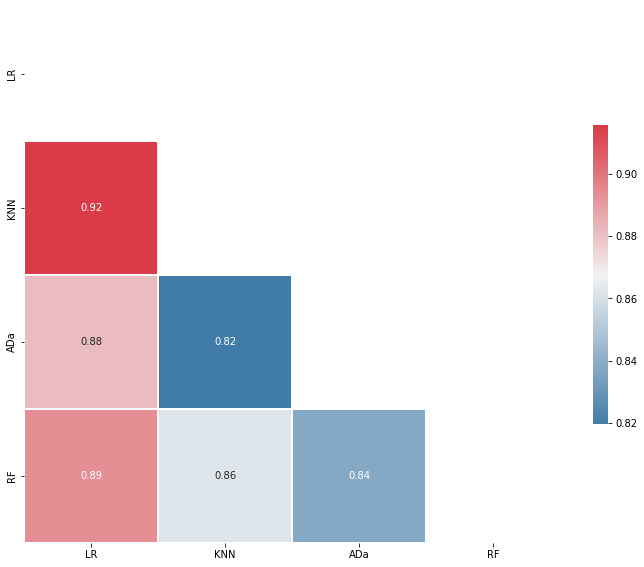

In [ ]:
# Plotando correlação entre os erros dos modelos nos dados originais
# Os erros são significativamente correlacionados, o que é esperado para modelos 
# com bom desempenho, pois normalmente são os valores discrepantes que são difíceis de acertar.
correlacoes(P)

O que os modelos com os dados filtrados tem a nos mostrar?

In [ ]:
models_f = dict(estimators_f)
P_f = train_predict(models_f,X_train_f,X_test_f,y_train,y_test)

Fitting models.
LR... done
KNN... done
ADa... done
RF... done
Done.



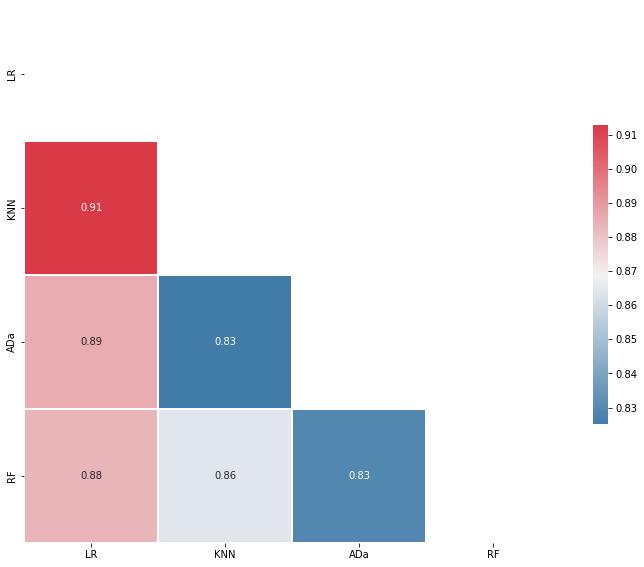

In [ ]:
# Plotando correlação entre os erros dos modelos nos dados filtrados
correlacoes(P_f)

### Avaliando os resultados com dados de teste

In [ ]:
def metrics_aval(y_test, y_pred, name_mod):
  df_metrics = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
  print(f'Relatório de Avaliação do modelo {name_mod}:')
  return df_metrics

y_preds = [y_pred_lr,y_pred_ada[0],y_pred_ensemble,y_pred_rf,y_pred_knn[0],y_pred_lr_f,y_pred_ada_f[0],y_pred_ensemble_f,y_pred_rf_f,y_pred_knn_f[0]]
names_models = ['y_pred_lr','y_pred_ada','y_pred_ensemble','y_pred_rf','y_pred_knn','y_pred_lr_f','y_pred_ada_f','y_pred_ensemble_f','y_pred_rf_f','y_pred_knn_f']

O ranking dos modelos

In [ ]:
list_auc = {'model':[], 'roc_auc':[]}

for i in range(len(y_preds)):
  list_auc['model'].append(names_models[i])
  list_auc['roc_auc'].append(roc_auc_score(y_test, y_preds[i]))

print('Modelos e as Áreas sob a Curva ROC')
df_auc = pd.DataFrame(list_auc['roc_auc'],list_auc['model'])
df_auc.columns = ['AUC']
df_auc.sort_values(by='AUC',ascending=False, inplace=True)
df_auc

Modelos e as Áreas sob a Curva ROC


,AUC
y_pred_ensemble,0.738253
y_pred_ensemble_f,0.735597
y_pred_ada,0.729935
y_pred_rf,0.729654
y_pred_ada_f,0.728501
y_pred_rf_f,0.726572
y_pred_knn,0.720794
y_pred_lr,0.718278
y_pred_lr_f,0.716848
y_pred_knn_f,0.716010


As principais métricas para os 3 melhores modelos

• Vou salvar o modelo `ensemble_model_f` (treinado com apenas 20 características) devido o resultado muito parecido com o `ensemble_model` (treinado com 62 características) devido o custo computacional.
Mais detalhes, ver sobre *O Princípio da Parcimônia*

In [ ]:
metrics_aval(y_test, y_preds[2], 'y_pred_ensemble')

Relatório de Avaliação do modelo y_pred_ensemble:


,precision,recall,f1-score,support
0,0.671196,0.708752,0.689463,697.000000
1,0.797607,0.767754,0.782396,1042.000000
accuracy,0.744106,0.744106,0.744106,0.744106
macro avg,0.734401,0.738253,0.735929,1739.000000
weighted avg,0.746941,0.744106,0.745148,1739.000000


In [ ]:
metrics_aval(y_test, y_preds[-3], 'y_pred_ensemble_f')

Relatório de Avaliação do modelo y_pred_ensemble_f:


,precision,recall,f1-score,support
0,0.660079,0.718795,0.688187,697.00000
1,0.800000,0.752399,0.775470,1042.00000
accuracy,0.738930,0.738930,0.738930,0.73893
macro avg,0.730040,0.735597,0.731828,1739.00000
weighted avg,0.743919,0.738930,0.740486,1739.00000


In [ ]:
metrics_aval(y_test, y_preds[3], 'y_pred_rf')

Relatório de Avaliação do modelo y_pred_rf:


,precision,recall,f1-score,support
0,0.669468,0.685796,0.677534,697.000000
1,0.786341,0.773512,0.779874,1042.000000
accuracy,0.738355,0.738355,0.738355,0.738355
macro avg,0.727905,0.729654,0.728704,1739.000000
weighted avg,0.739498,0.738355,0.738856,1739.000000


In [ ]:
# Salvando o modelo no disco

# import pickle
# filename = 'ensemble_model_f.sav'
# pickle.dump(ensemble_model_f,open(filename, 'wb'))

### Outras variaveis para criar e comparar os resultados (Resultado da etapa anterior de Análise Exploratória)

[_] QTD dias desde a primeira venda

[_] Qtd de pedidos cancelados

[_] O vendedor mora nas cidades e estados top 10 de vendas?

[_] Área do produto (e area + peso)

[_] O peso do altura está entre o 1º e 3º quartil?

[_] O peso do largura está entre o 1º e 3º quartil?

[_] O peso do produto está entre 300g e 1800g?

[_] O length_cm está entre 18 e 40?

[_] O produto tem ao menos 3 fotos?

[_] Tem tamanho da descricao entre 300 e 1200?

[_] Tem tamanho do nome do produto entre 40 e 60?

[_] Vendeu com parcelas entre 1 e 4?

[_] Vendeu parcelado em mais de 8x ?

[_] Vendeu algum produto das categorias mais frequentes?

[_] Tipo de pagamento mais frequênte

[_] o vendedor mora em SP(SP tem frete mais barato)?

[_] o vendedor mora no estado onde o frete é mais caro?

[_] média de frete por compra

[_] média de frete por cidade

[_] média de frete por estado

[_] a categoria mais vendida

[_] média de score

[_] média de score nos meses em que vende

[_] ultima nota de score

[_] a primeira compra teve score < 3?

[_] a ultima compra teve score < 3?

[_] o ultimo pedido atrasou?

[_] grupo do vendedor (critério=valor de compras($))

[_] grupo do vendedor (critério=total de pedidos)

[_] IDH da cidade

[_] IDH do estado

[_] escreveu um comentario com mais de 50 caracteres?

[_] o frete representa quantos % do valor total?

---

Referencias utilizadas no projeto ♥ Obrigado!:

In [ ]:
# https://www.kaggle.com/code/pouryaayria/a-complete-ml-pipeline-tutorial-acu-86/notebook

# https://medium.com/data-hackers/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-34e6f6011108

# https://www.flai.com.br/juscudilio/como-calcular-as-metricas-de-validacao-dos-modelos-de-machine-learning-em-python/